Clone the repository. It already has:
  * Configuration for the Faster RCNN
  * Bubble files and their COCO annotations
  * ROI pooling and mixed CNN files

In [1]:
!git clone https://github.com/hugalgo/bubble-detection.git
%cd bubble-detection/
!gdown --id 1PAHYQWSL9rm1SADaMTsK3AmjjOceMRXn -O models/FRCNN/latest.pth

Cloning into 'bubble-detection'...
remote: Enumerating objects: 10799, done.
remote: Counting objects: 100% (10799/10799), done.
remote: Compressing objects: 100% (3603/3603), done.
remote: Total 10799 (delta 7158), reused 10772 (delta 7131), pack-reused 0
Receiving objects: 100% (10799/10799), 12.45 MiB | 25.86 MiB/s, done.
Resolving deltas: 100% (7158/7158), done.
/content/bubble-detection
Downloading...
From: https://drive.google.com/uc?id=1PAHYQWSL9rm1SADaMTsK3AmjjOceMRXn
To: /content/bubble-detection/models/FRCNN/latest.pth
333MB [00:03, 93.9MB/s]


Install mmdetection that allow us to train a faster RCNN among others

In [2]:
%cd mmdetection/
!sh install.sh
%cd ..

/content/bubble-detection/mmdetection
     |████████████████████████████████| 20.0MB 1.2MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.18.4
    Uninstalling numpy-1.18.4:
      Successfully uninstalled numpy-1.18.4
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-s_kwvrt_
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-s_kwvrt_
  Created wheel for pycocotools: filename=pycocotools-2.0-cp36-cp36m-linux_x86_64.whl size=267027 sha256=3fba4e62d46b4e2a5a48619ac984ea53633d6a1f53ed9ccb10936341d780e050
  Stored in directory: /tmp/pip-ephem-wheel-cache-9yhprmaa/wheels/90/51/41/646daf401c3bc408ff10de34ec76587a9b3ebfac8d21ca5c3a
Successfully built pycocotools
Created temporary directory: /tmp/pip-ephem-wh

Training Faster RCNN

In [3]:
!python mmdetection/tools/train.py mmdetection/configs/faster_rcnn/faster_rcnn_r50_fpn_1x_coco-bubble.py

2020-05-26 20:57:09,413 - mmdet - INFO - Environment info:
------------------------------------------------------------
sys.platform: linux
Python: 3.6.9 (default, Apr 18 2020, 01:56:04) [GCC 8.4.0]
CUDA available: True
CUDA_HOME: /usr/local/cuda
NVCC: Cuda compilation tools, release 10.1, V10.1.243
GPU 0: Tesla P100-PCIE-16GB
GCC: gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
PyTorch: 1.5.0+cu101
PyTorch compiling details: PyTorch built with:
  - GCC 7.3
  - C++ Version: 201402
  - Intel(R) Math Kernel Library Version 2019.0.5 Product Build 20190808 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v0.21.1 (Git Hash 7d2fd500bc78936d1d648ca713b901012f470dbc)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 10.1
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_61,code=sm_61;-gencode;arch=compute_70,code=sm_70;-gen

Test trained RPN

In [4]:
!python mmdetection/tools/test.py mmdetection/configs/faster_rcnn/faster_rcnn_r50_fpn_1x_coco-bubble.py  \
    work_dirs/faster_rcnn_r50_fpn_1x_coco-bubble/latest.pth \
    --show-dir results

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
[>>] 2/2, 6.3 task/s, elapsed: 0s, ETA:     0s

Training Mixed CNN

Prepare the data to train:
json with rectangle and circle annotations


In [21]:
import scripts.roipooling as roi
XX, YY, ZZ = roi.obtainInOut('data/train_mixedcnn/','data/train_mixedcnn/result.json')
print(XX.shape)
print(YY.shape)
print(ZZ.shape)

(625, 10, 10, 3)
(625, 3)
(625, 4)


Create the mixed RCNN and training this model

In [22]:
import scripts.mixedcnn as mcnn
from keras.layers import concatenate
from keras.layers.core import Dense
from keras.models import Sequential
from keras.models import Model
from keras.optimizers import Adam # Other optimisers are available
from keras.callbacks import ModelCheckpoint

# Create the MLP and CNN models
mlp = mcnn.create_mlp(4)
cnn = mcnn.create_cnn(10, 10, 3)
 
# Create the input to the final set of layers as the output of both the MLP and CNN
combinedInput = concatenate([mlp.output, cnn.output])

# The final fully-connected layer head will have two dense layers (one relu and one sigmoid)
x = Dense(6, activation="relu")(combinedInput)
x = Dense(3)(x)

# The final model accepts numerical data on the MLP input and images on the CNN input, outputting a single value
model1 = Model(inputs=[mlp.input, cnn.input], outputs=x)

# Compile the model 
opt = Adam(lr=1e-3, decay=1e-3 / 200)
model1.compile(loss="mean_squared_error", metrics=['mse'], optimizer=opt)


model_checkpoint_callback = ModelCheckpoint(
    filepath='models/MixedCNN/best.h5',
    monitor='val_loss',
    mode='min',
    save_best_only=True)

# Train the model
model1_history = model1.fit([ZZ, XX],YY, epochs=100, validation_split = 0.2, batch_size=5, callbacks=[model_checkpoint_callback])

Train on 500 samples, validate on 125 samples
Epoch 1/100
500/500 [==============================] - 2s 3ms/step - loss: 2061.5928 - mse: 2061.5925 - val_loss: 1056.7900 - val_mse: 1056.7902
Epoch 2/100
500/500 [==============================] - 1s 2ms/step - loss: 648.9637 - mse: 648.9635 - val_loss: 473.9209 - val_mse: 473.9209
Epoch 3/100
500/500 [==============================] - 1s 2ms/step - loss: 339.1819 - mse: 339.1819 - val_loss: 280.5454 - val_mse: 280.5454
Epoch 4/100
500/500 [==============================] - 1s 2ms/step - loss: 208.9937 - mse: 208.9936 - val_loss: 179.3720 - val_mse: 179.3720
Epoch 5/100
500/500 [==============================] - 1s 2ms/step - loss: 135.4716 - mse: 135.4716 - val_loss: 115.1359 - val_mse: 115.1359
Epoch 6/100
500/500 [==============================] - 1s 2ms/step - loss: 90.6868 - mse: 90.6868 - val_loss: 74.1946 - val_mse: 74.1946
Epoch 7/100
500/500 [==============================] - 1s 2ms/step - loss: 63.1901 - mse: 63.1901 - val_loss

Printing all the training + validation predictions


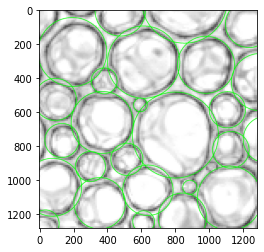

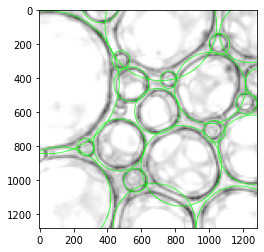

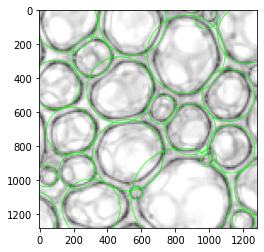

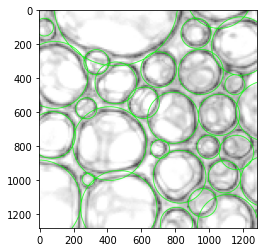

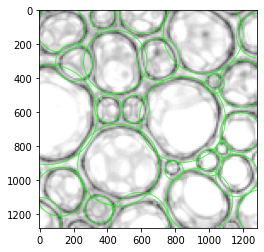

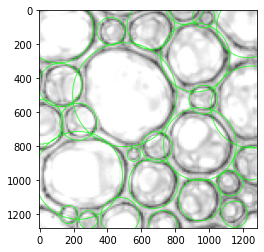

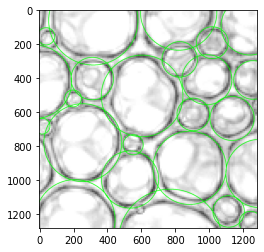

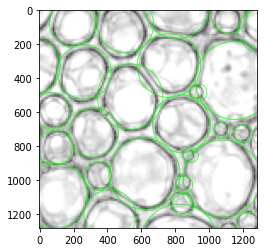

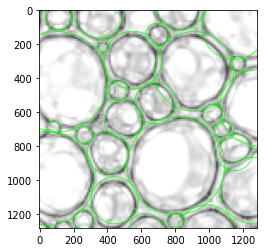

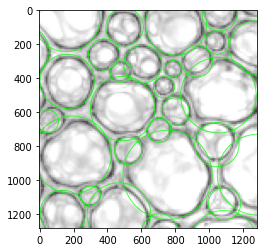

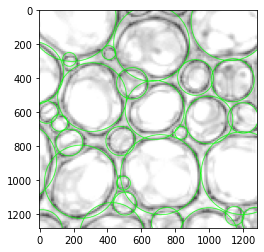

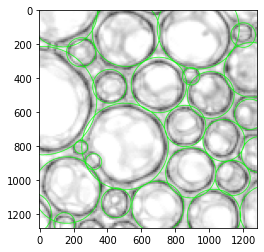

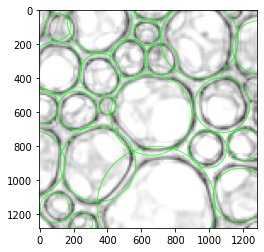

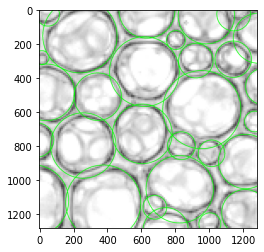

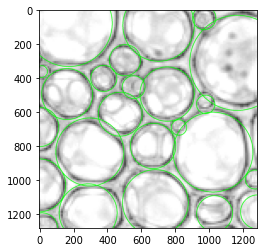

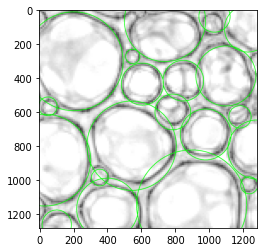

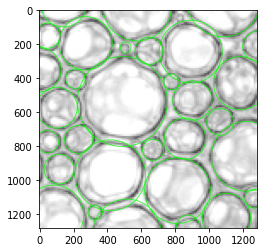

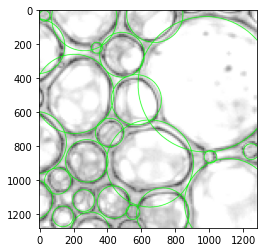

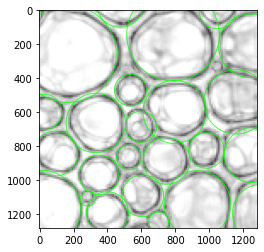

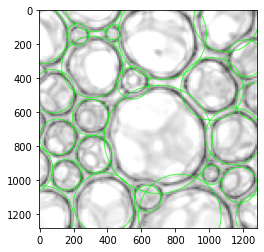

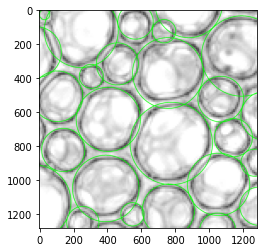

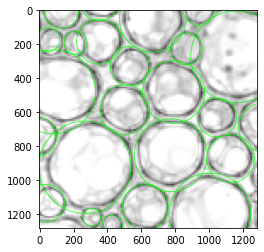

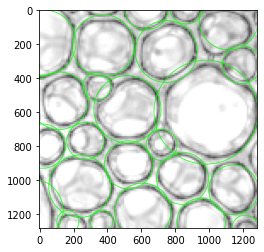

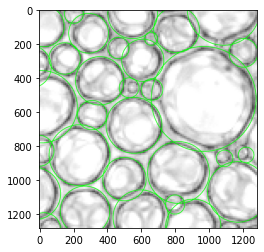

In [25]:
import matplotlib.image as mpimg
import numpy as np
from scipy import interpolate as inpo
import scripts.qbubble as qb
import os

from keras.models import load_model
model = load_model('models/MixedCNN/best.h5')

Yp =  model.predict([ZZ,XX])

impath = 'data/train_mixedcnn/'
jsonpath = 'data/train_mixedcnn/result.json'

arr = os.listdir(impath)
index = 0
dic = roi.loadjson(jsonpath)
for fi in arr:
    if('.png' in fi):
      img = mpimg.imread(impath+fi)[: ,: ,0]
      reg = dic[fi]
      v0 = []
      ii=0
      for ii in range(len(reg)):
        v0.append(np.array([Yp[ii+index][0], Yp[ii+index][1],Yp[ii+index][2]]))
      index+=ii+1
      qb.qbubblePlot(v0, img, s = 10, t = 3)